In [1]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [6]:
Train_file = []
# 数据文件夹
data_path =  r'C:\Users\zhang\Desktop\桌面资料\论文\AI_test\npy_file'
train_data_name = ['1glass_2500k.npy','2glass_2500k.npy','11glass_300k.npy','21glass_300k.npy',
                   '1cry_2500k.npy','2cry_2500k.npy','11crystal_300k.npy','21crystal_300k.npy',]

In [7]:
Train_data,Train_label = [],[]
for i in range(len(train_data_name)):
    Train_file.append(data_path + '\\'+ train_data_name[i])

In [8]:
def out_shape():
    print('Train_data:',np.array(Train_data).shape)
    print('Train_label:',np.array(Train_label).shape)

In [9]:
Train_data =  [np.load(data_path) for data_path in Train_file]
Train_label = [0] * 4000 + [1] * 4000

In [10]:
Train_data = np.array(Train_data ).reshape(-1,45,4)

In [11]:
out_shape()

Train_data: (8000, 45, 4)
Train_label: (8000,)


# # 模型建立与训练

In [3]:
class PointNet(nn.Module):
    def __init__(self):
        super(PointNet, self).__init__()
        
        # MLP做局部特征提取
        self.mlp1 = nn.Sequential(
            nn.Conv1d(4, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        
        # 提取全局特征
        self.mlp2 = nn.Sequential(
            nn.Conv1d(64, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 1024, 1),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        
        # 全连接网络进行分类
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)
    
    def forward(self, x):
        # 对输入张量x进行维度排列操作，将通道维度放在第二个位置。
        x = x.permute(0, 2, 1)
        
        # 局部特征提取
        x = self.mlp1(x)
        
        # 最大池化操作，以获得全局特征。
        x = torch.max(x, dim=2)[0]
        
        # 特征提取
        x = self.mlp2(x.unsqueeze(2))
        
        # 再次进行最大池化操作，以获得最终的全局特征
        x = torch.max(x, dim=2)[0]
        
        # 分类层
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        # 应用Softmax函数
        # x = torch.softmax(x, dim=-1)
        
        return x

In [4]:
# 参数设置
batch_size = 64
num_epochs = 50

In [15]:
# 将数据转换为Tensor
train_data = torch.Tensor(Train_data)
train_labels = torch.Tensor(Train_label).long()

# 创建数据集和数据加载器
dataset = torch.utils.data.TensorDataset(train_data, train_labels)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [6]:
# 创建PointNet模型实例
model = PointNet()
model.train()
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 保存loss最小的那次模型
best_loss = float('inf')  # 初始化为正无穷大
best_model_state_dict = None


# 准备数据集并进行训练
# 假设train_data是训练数据集，train_labels是对应的标签
list_loss = []
# 训练模型
for epoch in range(num_epochs):
    for batch_data, batch_labels in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
    # 找到最小的loss 并保存
    if loss.detach().numpy() < best_loss:
        best_loss = loss.detach().numpy()
        best_model_state_dict = model.state_dict()
    list_loss.append(loss)
    if epoch%20==0:
        print('Epochs:',epoch,' loss: ',loss.detach().numpy())

NameError: name 'dataloader' is not defined

Text(0.5, 1.0, 'Loss with epochs')

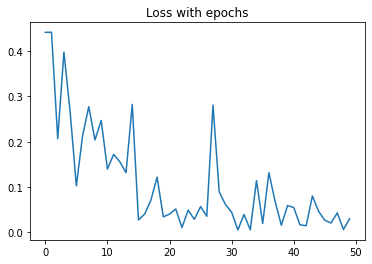

In [17]:
# 画图
list_loss_np_y = []
list_loss_x = []
for i in range(len(list_loss)):
    numpy_array = list_loss[i].detach().numpy()
    list_loss_np_y.append(numpy_array)
    list_loss_x.append(i)
plt.plot(list_loss_x,list_loss_np_y)
plt.title('Loss with epochs')

# 保存最好的那个模型
torch.save(best_model_state_dict, 'best_model.pth')


# 模型保存与加载

In [18]:
# 保存完整模型（包括模型结构和参数）
model_path = 'model_low_and_high.pth'
torch.save(model, model_path)

In [20]:
# 创建PointNet模型实例
model = PointNet()
# 加载完整模型
model = torch.load('model_500_95.pth')

# 模式测试

In [8]:
#  测试数据


test_data_name = ['3glass_2500k.npy','3cry_2500k.npy']
# data_path =  r'C:\Users\zhang\Desktop\桌面资料\论文\AI_test\npy_file'
Test_data,Test_label,Test_file = [],[],[]
for i in range(len(test_data_name)):
    Test_file.append(data_path + '\\' + test_data_name[i])

NameError: name 'data_path' is not defined

In [19]:
# 
Test_data =  [np.load(data_path) for data_path in Test_file]
Test_label = [0] * 1000 + [1] * 1000
Test_data = np.array(Test_data ).reshape(-1,45,4)
print('Test_data:',np.array(Test_data).shape)
print('Test_label:',np.array(Test_label).shape)

Test_data: (2000, 45, 4)
Test_label: (2000,)


In [20]:
# 将数据转换为Tensor
test_data = torch.Tensor(Test_data)
test_labels = torch.Tensor(Test_label).long()

# 创建测试数据集和数据加载器
test_dataset = torch.utils.data.TensorDataset(test_data, test_labels)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
# 设置模型为评估模式
model.eval()
probability_list = []
wrong_list = []
with torch.no_grad():
    correct = 0
    total = 0
    
    for batch_data, batch_labels in test_dataloader:
        outputs = model(batch_data)
        max_values, predicted = torch.max(outputs, dim=1)
        correct += (predicted == batch_labels).sum().item()
        # 
        probability_list.append(torch.softmax(outputs, dim=1))
        # 如果有错误的 看一下错误率差多少
        if (predicted == batch_labels).sum().item()<batch_size:
            wrong_list.append([predicted,batch_labels,torch.softmax(outputs, dim=1)])
        
    #print(predicted[:5])
    # 计算准确率
    total = test_data.size(0)
    accuracy = correct / total * 100
    print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 88.95%


In [22]:
correct

1779

# 查看正确率分布

In [23]:
for temp_list in wrong_list:
    for i in range(len(temp_list)):
        if (temp_list[0][i] != temp_list[1][i]).any():
            print(temp_list[2][i])

tensor([0.0028, 0.9972])
tensor([1.0844e-04, 9.9989e-01])
tensor([0.6241, 0.3759])
tensor([9.9997e-01, 3.3635e-05])
tensor([0.9982, 0.0018])
tensor([9.9997e-01, 2.7331e-05])
tensor([0.9650, 0.0350])
tensor([0.9355, 0.0645])
tensor([9.9901e-01, 9.9053e-04])
tensor([9.9957e-01, 4.3362e-04])
tensor([0.6193, 0.3807])


In [32]:
len(probability_list)

32

In [34]:
probalility = []
for i_list in probability_list:
    for j in i_list:
        probalility.append(j[0])

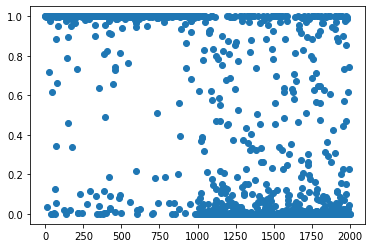

In [36]:
plt.scatter(range(len(probalility)),probalility)

In [41]:
print(len(probalility))
medium_i = []
for i in probalility:
    if 0.1<i<0.8:
        medium_i.append(i.float())
print(len(medium_i))

2000
153


# 模型预测

In [21]:
# 原有数据处理后的npy文件
npy_path = r'C:\Users\zhang\Desktop\桌面资料\论文\AI_test\26k-paper_data\26kcry_0p.npy'

# 原有的xyz文件
xyz_path = r'C:\Users\zhang\Desktop\桌面资料\论文\AI_test\26k-paper_data\old_2600k_0p.xyz'

# 新产生的xyz识别文件
new_xyz_path = r'C:\Users\zhang\Desktop\桌面资料\论文\AI_test\26k-paper_data\pre_2600k_0p.xyz'

In [22]:
Predict_data_list = np.load(npy_path)
Predict_label = np.zeros(len(Predict_data_list))
np.array(Predict_data_list).shape

(3000, 45, 4)

In [23]:
# 将数据转换为Tensor
predict_data = torch.Tensor(Predict_data_list)
predict_labels = torch.Tensor(Predict_label).long()

# 创建数据集和数据加载器
dataset = torch.utils.data.TensorDataset(predict_data, predict_labels)
pre_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [24]:
# 设置模型为评估模式
model.eval()
labe_lsit = []       # 记录预测标签的结果
proba_list = []  # 用于记录每个点的可能性
with torch.no_grad():
    for batch_data, batch_labels in pre_dataloader:
        outputs = model(batch_data)
        proba_list.append(torch.softmax(outputs, dim=1))
        _, predicted = torch.max(outputs.data, 1)
        labe_lsit.append(predicted)

# 将现有的label_list的tensor转为list
tensor_list = [tensor.tolist() for tensor in labe_lsit]
# 正儿八经的标签值
lab = []
for i in tensor_list:
    for j in i:
        lab.append(j)

In [25]:
pro_list = []
for i in proba_list:
    for j in i:
        pro_list.append(j.tolist())

In [26]:
# 将lab中的标签按照概率分分类
count=0
for i in range(3000):
    if 0.1<pro_list[i][0]<0.9:
        lab[i]=2
        count+=1
print(count)

173


In [27]:
# 为了便于总结，要把训练的相关信息输出 
cry_atoms = 0 
# 先读取原有的xyz文件
xyz_list = []
with open(xyz_path, 'r') as file:
    lines = file.readlines()
    for line in lines[2:]:  # 跳过前两行
        line = line.strip().split()
        atom = str(line[0])
        coordinates = [float(coord) for coord in line[1:]]
        xyz_list.append([atom] + coordinates)
# 先取出原有的Nb
Center_list = []
for i in xyz_list:
    if i[0]=='Nb':
         Center_list.append([i[1],i[2],i[3]])


In [28]:
# 再结合预测 输出新的xyz文件
with open(new_xyz_path,'w') as file:
    file.write('15000\n')
    file.write('Atoms\n')
    # 先把Nb写回去 玻璃是0 Si   记为 晶体是1 cry Nb
    for i in range(3000):
        if lab[i]==0:
            file.write('Si '+ str(Center_list[i][0])+' '+str(Center_list[i][1])+' '+str(Center_list[i][2])+'\n')
        if lab[i]==1:
            cry_atoms+=1
            file.write('Nb '+str(Center_list[i][0])+' '+str(Center_list[i][1])+' '+str(Center_list[i][2])+'\n')
        else:
            file.write('Ti '+str(Center_list[i][0])+' '+str(Center_list[i][1])+' '+str(Center_list[i][2])+'\n')
    # 再写回去其他原子
    for i in xyz_list:
        if i[0] != 'Nb':
            if i[0]== 'O':
                file.write('O '+str(i[1])+' '+str(i[2])+' '+str(i[3])+'\n')
            else:
                file.write('Li '+str(i[1])+' '+str(i[2])+' '+str(i[3])+'\n')
    print('新的xyz文件已经生成！')

新的xyz文件已经生成！


In [29]:
# 输出
print('Batch_size: ',batch_size,'     Epochs:',num_epochs)
print('Crystal_atom: ',cry_atoms)

Batch_size:  64      Epochs: 50
Crystal_atom:  279
